# Load the Instacart dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

Mounted at /content/drive/
2.0.0+cu118


In [2]:
%cd /content/drive/MyDrive/Gatech_MSA/CSE6240/
!ls

/content/drive/MyDrive/Gatech_MSA/CSE6240
 CSE6240-Instarcart-graph-project.gsheet
'CSE6240-potential project topic.gdoc'
'CSE 6240 - Spring 2023 Schedule and Syllabus.pdf'
 data
'Literature review.gdoc'
'node2vec try out.gdoc'
 notebooks
'Project proposal.gdoc'
'Proposal Report Rubric - Spring 2023.pdf'
 saved_model
'short note of the meeting Apr 5.gdoc'


In [3]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np

In [13]:
train_labels = pd.read_parquet(r'data/graphs/train_labels_neg.parquet')
val_labels = pd.read_parquet(r'data/graphs/val_labels_neg.parquet')
test_labels = pd.read_parquet(r'data/graphs/test_labels_neg.parquet')

train_edges = pd.read_parquet(r'data/graphs/train_edges.parquet')
val_edges = pd.read_parquet(r'data/graphs/val_edges.parquet')
test_edges = pd.read_parquet(r'data/graphs/test_edges.parquet')

preprocessing with enc_user_id

In [10]:
# enc_user_id = user_id + 50000
enc_user_id = train_edges[["user_id"]].drop_duplicates().sort_values("user_id").sort_values("user_id").reset_index(drop=True)
enc_user_id["enc_user_id"] = enc_user_id["user_id"] + 50000
print(enc_user_id.shape)
enc_user_id.head()

(101696, 2)


,user_id,enc_user_id
0,1,50001
1,2,50002
2,3,50003
3,7,50007
4,13,50013


In [14]:
# match the encode_user_id to train_edges
enc_user_id_dict = dict(zip(enc_user_id.user_id, enc_user_id.enc_user_id))
# encode_user_id
train_edges["enc_user_id"] = train_edges["user_id"].map(enc_user_id_dict)
val_edges["enc_user_id"] = val_edges["user_id"].map(enc_user_id_dict)
test_edges["enc_user_id"] = test_edges["user_id"].map(enc_user_id_dict)
train_labels["enc_user_id"] = train_labels["user_id"].map(enc_user_id_dict)
val_labels["enc_user_id"] = val_labels["user_id"].map(enc_user_id_dict)
test_labels["enc_user_id"] = test_labels["user_id"].map(enc_user_id_dict)

In [15]:
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

print(len(train_edges))
print(len(val_edges))
print(len(test_edges))

661052
661678
656406
8675721
9006247
9337086


In [16]:
print(train_edges)

         user_id  product_id    weight  enc_user_id
0              1         196  0.700000        50001
1              1       10258  0.600000        50001
2              1       10326  0.100000        50001
3              1       12427  0.700000        50001
4              1       13032  0.200000        50001
...          ...         ...       ...          ...
8675716   206209       41665  0.076923       256209
8675717   206209       43961  0.153846       256209
8675718   206209       44325  0.076923       256209
8675719   206209       48697  0.076923       256209
8675720   206209       48742  0.076923       256209

[8675721 rows x 4 columns]


In [17]:
# # retrive the existing edges for node2vec training
# pos_train_edge = train_labels[train_e['label']==1]
# pos_val_edge = val_labels[val_e['label']==1]
# pos_test_edge = test_label[test_e['label']==1]

# #pos_edge = pd.concat([pos_train_edge, pos_val_edge], ignore_index=True)
# pos_edge = pos_train_edge


In [18]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [26]:
# using total train_edge as training set for Node2vec model
pos_edge_idx = train_edges.loc[:, ["enc_user_id", "product_id"]].to_numpy().T
#pos_edge_idx = pos_edge.loc[:, ["user_id", "product_id"]].to_numpy().T
pos_edge_data=BipartiteData(edge_index=pos_edge_idx)

# convert the edge_index into tensor
pos_edge_data.edge_index = torch.from_numpy(pos_edge_data.edge_index)

# append the reverse edges
print(pos_edge_data.edge_index)
reverse_edge = pos_edge_data.edge_index[[1, 0]]
print(reverse_edge)
total_train_edge_idx = torch.concat((pos_edge_data.edge_index, reverse_edge), axis=1)
print(total_train_edge_idx)

tensor([[ 50001,  50001,  50001,  ..., 256209, 256209, 256209],
        [   196,  10258,  10326,  ...,  44325,  48697,  48742]])
tensor([[   196,  10258,  10326,  ...,  44325,  48697,  48742],
        [ 50001,  50001,  50001,  ..., 256209, 256209, 256209]])
tensor([[ 50001,  50001,  50001,  ...,  44325,  48697,  48742],
        [   196,  10258,  10326,  ..., 256209, 256209, 256209]])


In [28]:
print(total_train_edge_idx)
print(total_train_edge_idx.shape)

tensor([[ 50001,  50001,  50001,  ...,  44325,  48697,  48742],
        [   196,  10258,  10326,  ..., 256209, 256209, 256209]])
torch.Size([2, 17351442])


# Node2Vec embedding

In [29]:
# import library
from torch_geometric.nn import Node2Vec
import torch_geometric.utils
import os.path as osp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
# check if cuda is available to send the model and tensors to the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
# lower p=BFS
model = Node2Vec(total_train_edge_idx, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=2, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)  # data loader to speed the train 
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)  # initzialize the optimizer 

In [32]:
def train():
    model.train() # put model in the train model
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad() # set the gradient to zero
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) # compute the loss for the batch
        loss.backward()
        optimizer.step() # optimize the parameters
        total_loss += loss.item()
    return total_loss / len(loader)


for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 10, Loss: 0.8683
Epoch: 20, Loss: 0.8697
Epoch: 30, Loss: 0.8698
Epoch: 40, Loss: 0.8695
Epoch: 50, Loss: 0.8694
Epoch: 60, Loss: 0.8693
Epoch: 70, Loss: 0.8691
Epoch: 80, Loss: 0.8691
Epoch: 90, Loss: 0.8691
Epoch: 100, Loss: 0.8689


In [33]:
z = model()

In [34]:
with open(r"saved_model/node2vec_128_v2.pkl", "wb") as f:
    torch.save(z, f=f)

In [35]:
# test for loading Node2vec embedding
with open(r"saved_model/node2vec_128_v2.pkl", "rb") as f:
  z = torch.load(f)

# visualize node mbedding

In [36]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

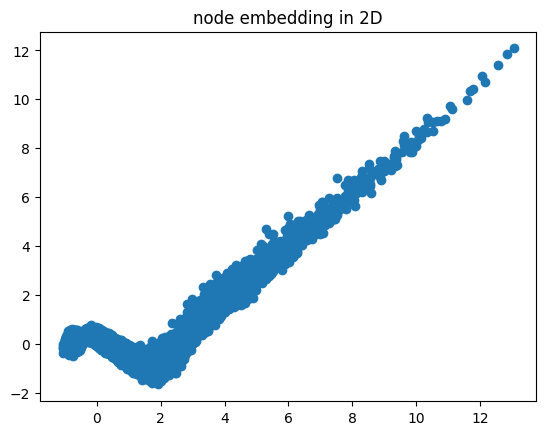

In [37]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

# Compute edge embedding using the Node2Vec embedding
using concatenate

In [38]:
print(train_labels.head(5))

   user_id  product_id  label  enc_user_id
0        1       46149      1        50001
1        1       49235      1        50001
2        1       32022      0        50001
3        1       44593      0        50001
4        2       47186      0        50002


In [39]:
# retrieving train/test edge from the pre-processed data set
print(train_labels.head(5))
X_train = torch.from_numpy(train_labels.loc[:, ["enc_user_id", "product_id"]].values.T)
print(X_train[:5])
y_train = torch.from_numpy(train_labels.loc[:, ["label"]].values.T).flatten()
print(y_train[:5])

print(test_labels.head(5))
X_test = torch.from_numpy(test_labels.loc[:, ["enc_user_id", "product_id"]].values.T)
print(X_test[:5])
y_test = torch.from_numpy(test_labels.loc[:, ["label"]].values.T).flatten()
print(y_test[:5])

print(emb_128[1])

   user_id  product_id  label  enc_user_id
0        1       46149      1        50001
1        1       49235      1        50001
2        1       32022      0        50001
3        1       44593      0        50001
4        2       47186      0        50002
tensor([[ 50001,  50001,  50001,  ..., 256209, 256209, 256209],
        [ 46149,  49235,  32022,  ...,  40310,  27857,  46898]])
tensor([1, 1, 0, 0, 0])
   user_id  product_id  label  enc_user_id
0        1       35951      1        50001
1        1       38928      1        50001
2        1       39657      1        50001
3        1        1838      0        50001
4        1       30792      0        50001
tensor([[ 50001,  50001,  50001,  ..., 256209, 256209, 256209],
        [ 35951,  38928,  39657,  ...,   6567,  28818,  37274]])
tensor([1, 1, 1, 0, 0])
[ 2.12792933e-01  6.97864816e-02  1.66061204e-02 -8.18190426e-02
  1.92668363e-01  3.04591268e-01  1.69583336e-01  2.50349909e-01
 -6.83202446e-02 -5.46933413e-02  1.16022257e-03

In [40]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2, 661052]) torch.Size([661052])
torch.Size([2, 656406]) torch.Size([656406])


In [41]:
# compute edge embedding
# X_train
X_train_edge_emb = []
for u, v in X_train.t():
    X_train_edge_emb.append(np.concatenate((emb_128[u], emb_128[v]), axis=0))

# X_test
X_test_edge_emb = []
for u, v in X_test.t():
    X_test_edge_emb.append(np.concatenate((emb_128[u], emb_128[v]), axis=0))

# link prediction classifier: MLP classifier

In [42]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train_edge_emb, y_train)
y_preds = mlp_clf.predict(X_test_edge_emb)
y_preds_proba = mlp_clf.predict_proba(X_test_edge_emb)

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
print("Accuracy: %.3f"%accuracy_score(y_test, y_preds))
print("Precision: %.3f"%precision_score(y_test, y_preds))
print("Recall: %.3f"%recall_score(y_test, y_preds))
print("F1_score: %.3f"%f1_score(y_test, y_preds))
print("Auc_roc_score(y_preds): %.3f"%roc_auc_score(y_test, y_preds))
print("Auc_roc_score(y_preds_proba): %.3f"%roc_auc_score(y_test, y_preds_proba[:, 1]))

Accuracy: 0.861
Precision: 0.860
Recall: 0.864
F1_score: 0.862
Auc_roc_score(y_preds): 0.861
Auc_roc_score(y_preds_proba): 0.935


In [44]:
print(roc_auc_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))

0.861413515415764
0.861413515415764


In [45]:
# test for import mlp model
import pickle
# save
with open('saved_model/node2vec_mlp_model.pkl','wb') as f:
    pickle.dump(mlp_clf,f)

In [46]:
# test for model loading
mlp_clf_try = pickle.load(open('saved_model/node2vec_mlp_model.pkl', "rb"))
y_preds = mlp_clf_try.predict(X_test_edge_emb)
y_preds_proba = mlp_clf_try.predict_proba(X_test_edge_emb)

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
print("Accuracy: %.3f"%accuracy_score(y_test, y_preds))
print("Precision: %.3f"%precision_score(y_test, y_preds))
print("Recall: %.3f"%recall_score(y_test, y_preds))
print("F1_score: %.3f"%f1_score(y_test, y_preds))
print("Auc_roc_score(y_preds): %.3f"%roc_auc_score(y_test, y_preds))
print("Auc_roc_score(y_preds_proba): %.3f"%roc_auc_score(y_test, y_preds_proba[:, 1]))

Accuracy: 0.861
Precision: 0.860
Recall: 0.864
F1_score: 0.862
Auc_roc_score(y_preds): 0.861
Auc_roc_score(y_preds_proba): 0.935
